# **Data Cleaning and Temporal Structuring of Martian REMS Observations**

## **1. Introduction**

### **Notebook Overview**
This notebook prepares raw REMS data collected by the Curiosity rover for analysis. The focus is on cleaning, standardizing, and structuring the dataset to ensure analytical consistency. Core tasks include:

- Identifying and quantifying missing values, placeholder strings, and index gaps.
- Standardizing temporal features and converting solar longitude into derived time constructs (Martian month, season, year).
- Applying imputation techniques where appropriate to restore continuity in the time series.

These steps establish a reliable foundation for downstream exploratory analysis and modeling workflows.

---

### **Dataset Description**
- **Dataset Source**: REMS data collected by the Curiosity Rover.
- **Key Columns**:
  - `Ls`: Solar longitude representing Mars’ position in its orbit.
  - `sunrise`, `sunset`: Times for sunrise and sunset. 
  - `max_ground_temp`, `min_ground_temp`: Ground temperature extremes.
  - `max_air_temp`, `min_air_temp`: Air temperature extremes.
  - `avg_air temp`, `avg_ground_temp`: Average air and ground temperatures.
  - `mars_month`: Martian month based on solar longitude (30  degrees per month)
  - `mars_year`: Martian year based on mission start (Initial year = 1)
  - `mars_season`: Martian season based on solar longitude. Curiosity is located in the southern hemisphere which means our seasons are inverted.
  - `day_length`: Length of the Martian day in minutes.
  - `mean_pressue`: Average atmospheric pressure for a given day.
  - `UV_Radiation`: UV index categories.
- Purpose: This dataset helps study Martian weather patterns and seasonal variations.

---

### **Notes on Seasons**
Martian seasons function similarly to those on Earth. Each season corresponds to a particular solar longitudinal range which are outlined as follows:
| Solar Longitude (°) | Season (Southern Hemisphere) |
|---------------------|----------------------------|
| 0 to 89            | Autumn (Fall)              |
| 90 to 179          | Winter                     |
| 180 to 269         | Spring                     |
| 270 to 359         | Summer                     |


---

### **Importing Packages and Configuring Directory Pathing**

In [39]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
sys.stderr = open(os.devnull, "w")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

from scipy.interpolate import interp1d
from datetime import datetime, timedelta
from utils.utilities import check_missing, gap_size, map_season, map_months, rolling_mode
from utils.time_handler import time_to_seconds, seconds_to_time

In [2]:
# Project directory configuration
DATA_PATH = '../data/'
PLOT_PATH = '../outputs/plots/'

## **2. Data Exploration**

### **2.1 Load and Inspect Data**

The dataset was sourced from [Kaggle](https://www.kaggle.com/datasets/deepcontractor/mars-rover-environmental-monitoring-station/data). It was create by the user "DEEP CONTRACTOR" by deriving features from the public datasets provided by NASA and collected by the Curiosity Rover REMS instrumentation.

In [3]:
# Load the CSV file into a Pandas DataFrame
mars_df = pd.read_csv(os.path.join(DATA_PATH, 'raw/REMS_Mars_Dataset.csv'))

In [4]:
# Initial Structure of DataFrame
mars_df.head()

,earth_date_time,mars_date_time,sol_number,max_ground_temp(°C),min_ground_temp(°C),max_air_temp(°C),min_air_temp(°C),mean_pressure(Pa),wind_speed(m/h),humidity(%),sunrise,sunset,UV_Radiation,weather
0,"Earth, 2022-01-26 UTC","Mars, Month 6 - LS 163°",Sol 3368,-3,-71,10,-84,707,Value not available,Value not available,05:25,17:20,moderate,Sunny
1,"Earth, 2022-01-25 UTC","Mars, Month 6 - LS 163°",Sol 3367,-3,-72,10,-87,707,Value not available,Value not available,05:25,17:20,moderate,Sunny
2,"Earth, 2022-01-24 UTC","Mars, Month 6 - LS 162°",Sol 3366,-4,-70,8,-81,708,Value not available,Value not available,05:25,17:21,moderate,Sunny
3,"Earth, 2022-01-23 UTC","Mars, Month 6 - LS 162°",Sol 3365,-6,-70,9,-91,707,Value not available,Value not available,05:26,17:21,moderate,Sunny
4,"Earth, 2022-01-22 UTC","Mars, Month 6 - LS 161°",Sol 3364,-7,-71,8,-92,708,Value not available,Value not available,05:26,17:21,moderate,Sunny


In [5]:
# Initial Datatypes and Missing Value Counts
mars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3197 entries, 0 to 3196
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   earth_date_time      3197 non-null   object
 1   mars_date_time       3197 non-null   object
 2   sol_number           3197 non-null   object
 3   max_ground_temp(°C)  3197 non-null   object
 4   min_ground_temp(°C)  3197 non-null   object
 5   max_air_temp(°C)     3197 non-null   object
 6   min_air_temp(°C)     3197 non-null   object
 7   mean_pressure(Pa)    3197 non-null   object
 8   wind_speed(m/h)      3197 non-null   object
 9   humidity(%)          3197 non-null   object
 10  sunrise              3197 non-null   object
 11  sunset               3197 non-null   object
 12  UV_Radiation         3170 non-null   object
 13  weather              3197 non-null   object
dtypes: object(14)
memory usage: 349.8+ KB


In [6]:
# Initial Summary Statistics
mars_df.describe()

,earth_date_time,mars_date_time,sol_number,max_ground_temp(°C),min_ground_temp(°C),max_air_temp(°C),min_air_temp(°C),mean_pressure(Pa),wind_speed(m/h),humidity(%),sunrise,sunset,UV_Radiation,weather
count,3197,3197,3197,3197,3197,3197,3197,3197,3197,3197,3197,3197,3170,3197
unique,3197,360,3197,52,40,51,78,224,1,1,90,96,4,2
top,"Earth, 2012-08-07 UTC","Mars, Month 4 - LS 93°",Sol 1,-6,-79,6,-78,873,Value not available,Value not available,05:18,17:20,moderate,Sunny
freq,1,12,1,130,221,154,165,47,3197,3197,170,199,1450,3194


### **2.2 Identify Missing Values**
There appears to be inconsistencies between different columns. 
 - `check_missing` function created to check for null and "Value not Available" fields.

In [7]:
check_missing(mars_df)

,NaN Count,"""Value not available"" Count",Total % Missing or Unavailable
wind_speed(m/h),0,3197,100.000000
humidity(%),0,3197,100.000000
max_air_temp(°C),0,29,0.907100
min_air_temp(°C),0,29,0.907100
min_ground_temp(°C),0,28,0.875821
max_ground_temp(°C),0,28,0.875821
UV_Radiation,27,0,0.844542
mean_pressure(Pa),0,27,0.844542
weather,0,3,0.093838
earth_date_time,0,0,0.000000


In [8]:
print("Number of unique values in 'column_name':")
mars_df.nunique()

Number of unique values in 'column_name':


earth_date_time        3197
mars_date_time          360
sol_number             3197
max_ground_temp(°C)      52
min_ground_temp(°C)      40
max_air_temp(°C)         51
min_air_temp(°C)         78
mean_pressure(Pa)       224
wind_speed(m/h)           1
humidity(%)               1
sunrise                  90
sunset                   96
UV_Radiation              4
weather                   2
dtype: int64

In [9]:
print("Unique UV Radiation Readings: ", mars_df['UV_Radiation'].unique())
print("Unique Weather Readings: ", mars_df['weather'].unique())

Unique UV Radiation Readings:  ['moderate' 'low' 'high' 'very_high' nan]
Unique Weather Readings:  ['Sunny' 'Value not available']


### **Notes**
 - Wind Speed and Humidity columns contain only missing data; they should be dropped.
 - Weather appears to only have one valid entry type. This column should be dropped as well.
 - The 'mars_date_time' column needs reformatting. This column should be split into seperate columns for Solar Longitude and Mars Month .
 - The 'sol_number' column should have the text 'sol' removed.
 - Sol number should also become the index of the dataframe.
 - UV Radiation should be mapped into a numerical format for ease of analysis.

---

## **3. Data Cleaning**

### **3.1 Drop Irrelevant Columns**

In [10]:
columns_to_drop = ['wind_speed(m/h)', 'humidity(%)', 'weather']
mars_df.drop(columns=columns_to_drop, inplace=True)

In [11]:
mars_df.head()

,earth_date_time,mars_date_time,sol_number,max_ground_temp(°C),min_ground_temp(°C),max_air_temp(°C),min_air_temp(°C),mean_pressure(Pa),sunrise,sunset,UV_Radiation
0,"Earth, 2022-01-26 UTC","Mars, Month 6 - LS 163°",Sol 3368,-3,-71,10,-84,707,05:25,17:20,moderate
1,"Earth, 2022-01-25 UTC","Mars, Month 6 - LS 163°",Sol 3367,-3,-72,10,-87,707,05:25,17:20,moderate
2,"Earth, 2022-01-24 UTC","Mars, Month 6 - LS 162°",Sol 3366,-4,-70,8,-81,708,05:25,17:21,moderate
3,"Earth, 2022-01-23 UTC","Mars, Month 6 - LS 162°",Sol 3365,-6,-70,9,-91,707,05:26,17:21,moderate
4,"Earth, 2022-01-22 UTC","Mars, Month 6 - LS 161°",Sol 3364,-7,-71,8,-92,708,05:26,17:21,moderate


### **3.2 Handling Temporal Features**

#### **Setting the index of the dataframe to 'sol'**

In [12]:
# Reformat sol_number and set as index
mars_df['sol_number'] = mars_df['sol_number'].str.replace('sol', '', case=False).str.strip().astype(int)

# Set 'sol_number' as DataFrame index
mars_df.set_index('sol_number', inplace=True)

# Invert the DataFrame index using slicing
mars_df = mars_df.iloc[::-1]

# Check DataFrame for new index
mars_df.head()

,earth_date_time,mars_date_time,max_ground_temp(°C),min_ground_temp(°C),max_air_temp(°C),min_air_temp(°C),mean_pressure(Pa),sunrise,sunset,UV_Radiation
sol_number,,,,,,,,,,
1,"Earth, 2012-08-07 UTC","Mars, Month 6 - LS 150°",Value not available,Value not available,Value not available,Value not available,Value not available,05:30,17:22,NaN
9,"Earth, 2012-08-15 UTC","Mars, Month 6 - LS 155°",Value not available,Value not available,Value not available,Value not available,Value not available,05:28,17:22,NaN
10,"Earth, 2012-08-16 UTC","Mars, Month 6 - LS 155°",-16,-75,8,-83,739,05:28,17:22,very_high
11,"Earth, 2012-08-17 UTC","Mars, Month 6 - LS 156°",-11,-76,9,-83,740,05:28,17:21,very_high
12,"Earth, 2012-08-18 UTC","Mars, Month 6 - LS 156°",-18,-76,8,-82,741,05:28,17:21,very_high


#### **Extract Solar Longitude from 'mars_date_time' column**

In [13]:
# Use a regular expression to extract the degree value from 'mars_date_time'
mars_df['Ls'] = mars_df['mars_date_time'].str.extract(r'LS\s+(\d+)°')[0].astype(float)

# Drop the 'mars_date_time' column
mars_df.drop(columns=['mars_date_time'], inplace=True)

# Verify DataFrame Structure
mars_df.head()

,earth_date_time,max_ground_temp(°C),min_ground_temp(°C),max_air_temp(°C),min_air_temp(°C),mean_pressure(Pa),sunrise,sunset,UV_Radiation,Ls
sol_number,,,,,,,,,,
1,"Earth, 2012-08-07 UTC",Value not available,Value not available,Value not available,Value not available,Value not available,05:30,17:22,NaN,150.0
9,"Earth, 2012-08-15 UTC",Value not available,Value not available,Value not available,Value not available,Value not available,05:28,17:22,NaN,155.0
10,"Earth, 2012-08-16 UTC",-16,-75,8,-83,739,05:28,17:22,very_high,155.0
11,"Earth, 2012-08-17 UTC",-11,-76,9,-83,740,05:28,17:21,very_high,156.0
12,"Earth, 2012-08-18 UTC",-18,-76,8,-82,741,05:28,17:21,very_high,156.0


#### **Clean 'earth_date_time'**

In [14]:
# Strip text from date
mars_df['earth_date_time'] = mars_df['earth_date_time'].str.replace('Earth, ', '', case=False).str.replace('UTC', '', case=False).str.strip()

# Convert to datetime
mars_df['earth_date_time'] = pd.to_datetime(mars_df['earth_date_time'])

# Verify change
mars_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3197 entries, 1 to 3368
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   earth_date_time      3197 non-null   datetime64[ns]
 1   max_ground_temp(°C)  3197 non-null   object        
 2   min_ground_temp(°C)  3197 non-null   object        
 3   max_air_temp(°C)     3197 non-null   object        
 4   min_air_temp(°C)     3197 non-null   object        
 5   mean_pressure(Pa)    3197 non-null   object        
 6   sunrise              3197 non-null   object        
 7   sunset               3197 non-null   object        
 8   UV_Radiation         3170 non-null   object        
 9   Ls                   3197 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 274.7+ KB


### **3.3 Handling Data Types and Naming**

#### **Map UV Radiation Values to Numerical Format**

In [15]:
# Create mapping for UV_Radiation levels
uv_mapping = {
    'low': 1,
    'moderate': 2,
    'high': 3,
    'very_high': 4
}

# Apply UV Mapping Schema
mars_df['UV_Radiation'] = mars_df['UV_Radiation'].map(uv_mapping).astype('Int64') # Int64 handles Null Values better than float for this purpose

# Verify the transformation
print(mars_df['UV_Radiation'].unique())

<IntegerArray>
[<NA>, 4, 3, 2, 1]
Length: 5, dtype: Int64


#### **Convert 'Value not available' to np.NaN**

In [16]:
mars_df.replace("Value not available", np.nan, inplace=True)
print(check_missing(mars_df))

                     NaN Count  "Value not available" Count  \
min_air_temp(°C)            29                            0   
max_air_temp(°C)            29                            0   
min_ground_temp(°C)         28                            0   
max_ground_temp(°C)         28                            0   
UV_Radiation                27                            0   
mean_pressure(Pa)           27                            0   
earth_date_time              0                            0   
sunrise                      0                            0   
sunset                       0                            0   
Ls                           0                            0   

                     Total % Missing or Unavailable  
min_air_temp(°C)                             0.9071  
max_air_temp(°C)                             0.9071  
min_ground_temp(°C)                        0.875821  
max_ground_temp(°C)                        0.875821  
UV_Radiation                        

#### **Renaming Temperature and Pressure Columns to Remove Units**
- Temperature data will remain in Celcius (°C).
- Pressure will remain in Pascals (Pa).

In [17]:
# Rename columns to remove "(°C)"
mars_df.rename(columns={
    'max_ground_temp(°C)': 'max_ground_temp',
    'min_ground_temp(°C)': 'min_ground_temp',
    'max_air_temp(°C)': 'max_air_temp',
    'min_air_temp(°C)': 'min_air_temp',
    'mean_pressure(Pa)': 'mean_pressure'
}, inplace=True)

In [18]:
mars_df.head()

,earth_date_time,max_ground_temp,min_ground_temp,max_air_temp,min_air_temp,mean_pressure,sunrise,sunset,UV_Radiation,Ls
sol_number,,,,,,,,,,
1,2012-08-07,NaN,NaN,NaN,NaN,NaN,05:30,17:22,<NA>,150.0
9,2012-08-15,NaN,NaN,NaN,NaN,NaN,05:28,17:22,<NA>,155.0
10,2012-08-16,-16,-75,8,-83,739,05:28,17:22,4,155.0
11,2012-08-17,-11,-76,9,-83,740,05:28,17:21,4,156.0
12,2012-08-18,-18,-76,8,-82,741,05:28,17:21,4,156.0


#### **Adjusting Remaining Data Types**

In [19]:
# Set temperatures to float
mars_df['max_ground_temp'] = mars_df['max_ground_temp'].astype(float) # Ground Temperatures
mars_df['min_ground_temp'] = mars_df['min_ground_temp'].astype(float)

mars_df['max_air_temp'] = mars_df['max_air_temp'].astype(float) # Air Temperatures
mars_df['min_air_temp'] = mars_df['min_air_temp'].astype(float)

# Set Pressure to float
mars_df['mean_pressure'] = mars_df['mean_pressure'].astype(float)

# Set Sunrise/Sunset to Datetime
mars_df['sunrise'] = pd.to_datetime(mars_df['sunrise'], format='%H:%M').dt.time
mars_df['sunset'] = pd.to_datetime(mars_df['sunset'], format='%H:%M').dt.time

In [20]:
mars_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3197 entries, 1 to 3368
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   earth_date_time  3197 non-null   datetime64[ns]
 1   max_ground_temp  3169 non-null   float64       
 2   min_ground_temp  3169 non-null   float64       
 3   max_air_temp     3168 non-null   float64       
 4   min_air_temp     3168 non-null   float64       
 5   mean_pressure    3170 non-null   float64       
 6   sunrise          3197 non-null   object        
 7   sunset           3197 non-null   object        
 8   UV_Radiation     3170 non-null   Int64         
 9   Ls               3197 non-null   float64       
dtypes: Int64(1), datetime64[ns](1), float64(6), object(2)
memory usage: 277.9+ KB


##### **Note**
In Pandas, 'datetime.time' objects are not native and will still show as the 'object' data type. They are however, still in a datetime format suitable for calculations.

In [21]:
mars_df.head()

,earth_date_time,max_ground_temp,min_ground_temp,max_air_temp,min_air_temp,mean_pressure,sunrise,sunset,UV_Radiation,Ls
sol_number,,,,,,,,,,
1,2012-08-07,NaN,NaN,NaN,NaN,NaN,05:30:00,17:22:00,<NA>,150.0
9,2012-08-15,NaN,NaN,NaN,NaN,NaN,05:28:00,17:22:00,<NA>,155.0
10,2012-08-16,-16.0,-75.0,8.0,-83.0,739.0,05:28:00,17:22:00,4,155.0
11,2012-08-17,-11.0,-76.0,9.0,-83.0,740.0,05:28:00,17:21:00,4,156.0
12,2012-08-18,-18.0,-76.0,8.0,-82.0,741.0,05:28:00,17:21:00,4,156.0


### **3.3 Feature Engineering**

#### **Adding Day Length**

In [22]:
# Convert sunrise times to seconds
mars_df['sunrise_seconds'] = mars_df['sunrise'].apply(time_to_seconds)
mars_df['sunset_seconds'] = mars_df['sunset'].apply(time_to_seconds)

# Create new column for total sunlight called 'day length'
mars_df['day_length'] = ((mars_df['sunset_seconds'] - mars_df['sunrise_seconds']) / 60).round(1)

# Convert interpolated seconds back to time format
mars_df['sunrise'] = mars_df['sunrise_seconds'].apply(seconds_to_time)
mars_df['sunset'] = mars_df['sunset_seconds'].apply(seconds_to_time)

# Drop helper columns
mars_df.drop(columns=['sunrise_seconds'], inplace=True)
mars_df.drop(columns=['sunset_seconds'], inplace=True)

# Verify the updated DataFrame
print(mars_df[['sunrise', 'sunset', 'day_length']].head(10))

             sunrise    sunset  day_length
sol_number                                
1           05:30:00  17:22:00       712.0
9           05:28:00  17:22:00       714.0
10          05:28:00  17:22:00       714.0
11          05:28:00  17:21:00       713.0
12          05:28:00  17:21:00       713.0
13          05:28:00  17:21:00       713.0
14          05:27:00  17:21:00       714.0
15          05:27:00  17:21:00       714.0
16          05:27:00  17:21:00       714.0
17          05:27:00  17:21:00       714.0


#### **Adding Martian Date and Seasons**

In [23]:
# Add Martian Month Column
mars_df['mars_month'] = mars_df['Ls'].apply(map_months) # Based on Solar Longitude

# Add Martian Season Column
mars_df['mars_season'] = mars_df['Ls'].apply(map_season) # Based on Solar Longitude

# Calculate year colum.
year = 1 # Initial mission year
years = []
prev_ls = 0

for current_ls in mars_df['Ls']:
    if pd.notnull(current_ls): # Ensures non-null value
        if prev_ls > current_ls:
            year += 1 # Increments every time Mars completes a full orbit around the Sun
        prev_ls = current_ls
    years.append(year)

mars_df['mars_year'] = years 

# Verify the results
print(mars_df[['Ls', 'mars_season', 'mars_month', 'mars_year']].sample(5))

               Ls mars_season  mars_month  mars_year
sol_number                                          
3061         18.0      autumn           1          6
1885         91.0      winter           4          4
2286        321.0      summer          11          4
3258        108.0      winter           4          6
178         258.0      spring           9          1


In [24]:
# Add columns for average temperatures
mars_df['avg_ground_temp'] = mars_df[['max_ground_temp', 'min_ground_temp']].mean(axis=1)
mars_df['avg_air_temp'] = mars_df[['max_air_temp', 'min_air_temp']].mean(axis=1)

#### **Reorganizing DataFrame**

In [25]:
# Reorder columns based on temporal focus
column_order = [
    # Time and Orbital Data
    'earth_date_time', 'Ls', 'mars_month', 'mars_year', 'mars_season',
    
    # Solar Information
    'sunrise', 'sunset', 'day_length',
    
    # Temperature Data
    'avg_ground_temp', 'max_ground_temp', 'min_ground_temp',
    'avg_air_temp', 'max_air_temp', 'min_air_temp',
    
    # Other Environmental Data
    'mean_pressure', 'UV_Radiation'
]

# Reorder the DataFrame columns
mars_df = mars_df[column_order]

# Verify New DataFrame Structure
mars_df.head()

,earth_date_time,Ls,mars_month,mars_year,mars_season,sunrise,sunset,day_length,avg_ground_temp,max_ground_temp,min_ground_temp,avg_air_temp,max_air_temp,min_air_temp,mean_pressure,UV_Radiation
sol_number,,,,,,,,,,,,,,,,
1,2012-08-07,150.0,6,1,winter,05:30:00,17:22:00,712.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
9,2012-08-15,155.0,6,1,winter,05:28:00,17:22:00,714.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
10,2012-08-16,155.0,6,1,winter,05:28:00,17:22:00,714.0,-45.5,-16.0,-75.0,-37.5,8.0,-83.0,739.0,4
11,2012-08-17,156.0,6,1,winter,05:28:00,17:21:00,713.0,-43.5,-11.0,-76.0,-37.0,9.0,-83.0,740.0,4
12,2012-08-18,156.0,6,1,winter,05:28:00,17:21:00,713.0,-47.0,-18.0,-76.0,-37.0,8.0,-82.0,741.0,4


### **3.5 Filling in Data Gaps**
 - Temperature columns will be linearly interpolated based on neighbors.
 - Pressure will be similarly linearly interpolated based on neighbors.
 - UV Radiation readings will use a `rolling_mode` function to fill in gaps with the mode for a 30 day window. This ensures that filled values are consistent with local trends.

In [26]:
# Interpolate missing temperature values
temperature_columns = ['max_ground_temp', 'min_ground_temp', 'max_air_temp', 'min_air_temp', 'avg_ground_temp', 'avg_air_temp']
mars_df[temperature_columns] = mars_df[temperature_columns].interpolate(method='linear', limit_direction='both').round(1)

# Interpolate missing pressure values
mars_df['mean_pressure'] = mars_df['mean_pressure'].interpolate(method='linear', limit_direction='both').round(1)

# Apply the rolling mode function to UV_Radiation
mars_df['UV_Radiation'] = rolling_mode(mars_df['UV_Radiation'], window=30)

### **Identifying Gaps in Solar Number for Later Use**
There are missing Martian days. The reason for their abscence is unknkown, so it might be interesting to save these missing days for later analysis.

In [27]:
# Generate the full range of sol numbers
full_range = pd.RangeIndex(start=mars_df.index.min(), stop=mars_df.index.max() + 1)

# Check for missing sol numbers
missing_sols = full_range.difference(mars_df.index)
print("Missing sol numbers:", missing_sols.tolist())

# Check for repeated sol numbers
repeated_sols = mars_df.index[mars_df.index.duplicated()].unique()
print("Repeated sol numbers:", repeated_sols.tolist())

# Creating Gap Summary DataFrame 
gap_summary = gap_size(mars_df)

gap_summary.to_csv(os.path.join(DATA_PATH, 'cleaned/data_gaps.csv'), index=False)

# Display the gap summary
print("Gap Summary for All Columns:")
print(gap_summary.info())  # Display the first 15 gaps

Missing sol numbers: [2, 3, 4, 5, 6, 7, 8, 193, 194, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 216, 217, 218, 219, 220, 221, 263, 264, 265, 266, 359, 360, 361, 362, 363, 364, 445, 446, 447, 448, 449, 450, 451, 452, 453, 458, 459, 460, 461, 479, 480, 481, 482, 483, 484, 873, 874, 875, 876, 877, 878, 879, 938, 955, 956, 999, 1027, 1289, 1290, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1691, 1786, 2175, 2176, 2177, 2178, 2179, 2180, 2181, 2182, 2183, 2184, 2185, 2186, 2187, 2188, 2189, 2190, 2191, 2192, 2193, 2194, 2195, 2196, 2197, 2198, 2199, 2200, 2201, 2202, 2203, 2215, 2259, 2260, 2262, 2320, 2321, 2322, 2323, 2324, 2325, 2326, 2327, 2328, 2329, 2330, 2331, 2332, 2339, 2340, 2341, 2342, 2343, 2344, 2345, 2346, 2706, 2739, 2740, 2808, 2809, 2815, 2966, 3024, 3124, 3125, 3126, 3127, 3128, 3129, 3184, 3254, 3255, 3256, 3257, 3273, 3306, 3333, 3334, 3335, 3336, 3337, 3338, 3339, 3340, 3341, 3342, 3343, 3344, 3354]
Repeated sol numbers: []
Gap Summar

## **4. Summary Statistics**

### **4.1 Sanity Check**
Double check to ensure data cleaning did not yield unexpected results.

In [28]:
# Check current data types
mars_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3197 entries, 1 to 3368
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   earth_date_time  3197 non-null   datetime64[ns]
 1   Ls               3197 non-null   float64       
 2   mars_month       3197 non-null   int64         
 3   mars_year        3197 non-null   int64         
 4   mars_season      3197 non-null   object        
 5   sunrise          3197 non-null   object        
 6   sunset           3197 non-null   object        
 7   day_length       3197 non-null   float64       
 8   avg_ground_temp  3197 non-null   float64       
 9   max_ground_temp  3197 non-null   float64       
 10  min_ground_temp  3197 non-null   float64       
 11  avg_air_temp     3197 non-null   float64       
 12  max_air_temp     3197 non-null   float64       
 13  min_air_temp     3197 non-null   float64       
 14  mean_pressure    3197 non-null   float64     

In [29]:
check_missing(mars_df)

,NaN Count,"""Value not available"" Count",Total % Missing or Unavailable
earth_date_time,0,0,0.0
Ls,0,0,0.0
mars_month,0,0,0.0
mars_year,0,0,0.0
mars_season,0,0,0.0
sunrise,0,0,0.0
sunset,0,0,0.0
day_length,0,0,0.0
avg_ground_temp,0,0,0.0
max_ground_temp,0,0,0.0


#### **View of Cleaned Mars Weather DataFrame**

In [30]:
mars_df.head(10)

,earth_date_time,Ls,mars_month,mars_year,mars_season,sunrise,sunset,day_length,avg_ground_temp,max_ground_temp,min_ground_temp,avg_air_temp,max_air_temp,min_air_temp,mean_pressure,UV_Radiation
sol_number,,,,,,,,,,,,,,,,
1,2012-08-07,150.0,6,1,winter,05:30:00,17:22:00,712.0,-45.5,-16.0,-75.0,-37.5,8.0,-83.0,739.0,4
9,2012-08-15,155.0,6,1,winter,05:28:00,17:22:00,714.0,-45.5,-16.0,-75.0,-37.5,8.0,-83.0,739.0,4
10,2012-08-16,155.0,6,1,winter,05:28:00,17:22:00,714.0,-45.5,-16.0,-75.0,-37.5,8.0,-83.0,739.0,4
11,2012-08-17,156.0,6,1,winter,05:28:00,17:21:00,713.0,-43.5,-11.0,-76.0,-37.0,9.0,-83.0,740.0,4
12,2012-08-18,156.0,6,1,winter,05:28:00,17:21:00,713.0,-47.0,-18.0,-76.0,-37.0,8.0,-82.0,741.0,4
13,2012-08-19,157.0,6,1,winter,05:28:00,17:21:00,713.0,-44.5,-15.0,-74.0,-36.0,8.0,-80.0,732.0,4
14,2012-08-20,157.0,6,1,winter,05:27:00,17:21:00,714.0,-45.0,-16.0,-74.0,-36.5,9.0,-82.0,740.0,4
15,2012-08-21,158.0,6,1,winter,05:27:00,17:21:00,714.0,-46.5,-15.0,-78.0,-37.0,8.0,-82.0,740.0,4
16,2012-08-22,158.0,6,1,winter,05:27:00,17:21:00,714.0,-38.5,0.0,-77.0,-36.0,9.0,-81.0,740.0,4


In [31]:
# Save cleaned dataframe to CSV format
mars_df.to_csv(os.path.join(DATA_PATH, 'cleaned/mars_weather_cleaned.csv')) # Saves to data/cleaned/

---

## **. Visualizations**

### **5.1 Day Length Visualization**

#### **Visualization of Day Length Over Martian Year**
I want to visualize the day length with index color segmentation to double check that no datapoints are misbehaving based on my imputation strategy.

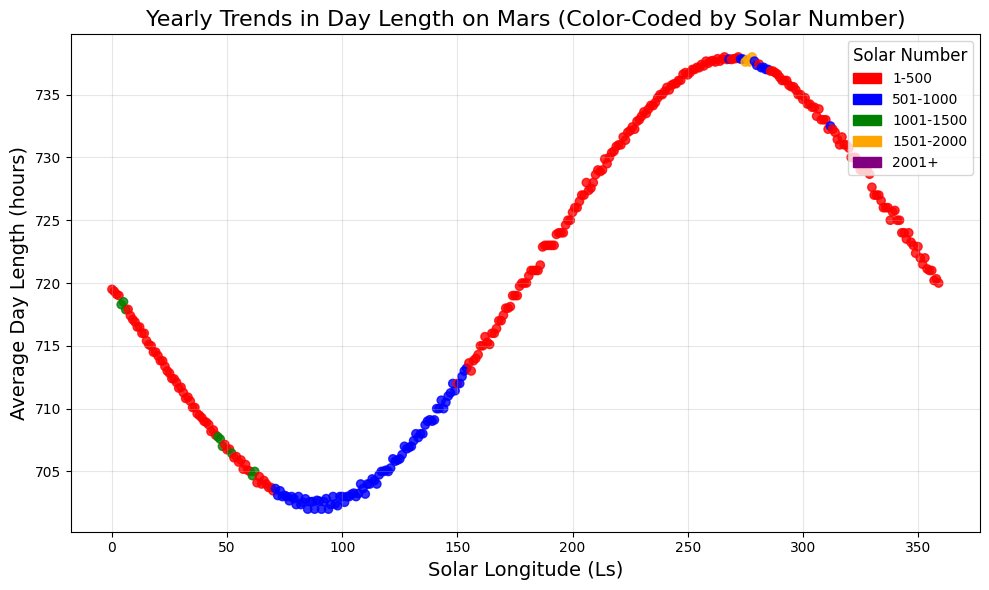

In [32]:
# Add a color category based on the index ranges
def assign_color(index):
    if index <= 500:
        return 'red'
    elif index <= 1000:
        return 'blue'
    elif index <= 1500:
        return 'green'
    elif index <= 2000:
        return 'orange'
    else:
        return 'purple'

# Apply the map function to create a new column for colors
mars_df['color'] = mars_df.index.map(assign_color)

# Group the data by solar longitude (Ls) and calculate mean day length
mars_yearly_day_length = mars_df.groupby('Ls')['day_length'].mean()

# Extract corresponding colors for the grouped data
grouped_colors = mars_df.groupby('Ls')['color'].first()

# Drop Color Column
mars_df.drop(columns='color', inplace=True)

# Plot the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(
    mars_yearly_day_length.index,
    mars_yearly_day_length.values,
    c=grouped_colors.values,
    alpha=0.8
)
plt.title('Yearly Trends in Day Length on Mars (Color-Coded by Solar Number)', fontsize=16)
plt.xlabel('Solar Longitude (Ls)', fontsize=14)
plt.ylabel('Average Day Length (hours)', fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()

# Add a custom legend for the index ranges
legend_handles = [
    mpatches.Patch(color='red', label='1-500'),
    mpatches.Patch(color='blue', label='501-1000'),
    mpatches.Patch(color='green', label='1001-1500'),
    mpatches.Patch(color='orange', label='1501-2000'),
    mpatches.Patch(color='purple', label='2001+')
]
plt.legend(handles=legend_handles, title='Solar Number', fontsize=10, title_fontsize=12, loc='upper right')

# Save and show the plot
plt.savefig(os.path.join(PLOT_PATH, '01 - Yearly Trends in Day Length on Mars (Color-Coded by Solar Number).png'))
plt.show()

### **5.2 Temperature Visualizations**
Initial view of air temperature over a year.
 - `X-Axis`: Temperature in Celcius (°C)
 - `Y-Axis`: Solar Longitude (Ls)

#### **Basic Visualization of Yearly Trends for Average Air Temperature**

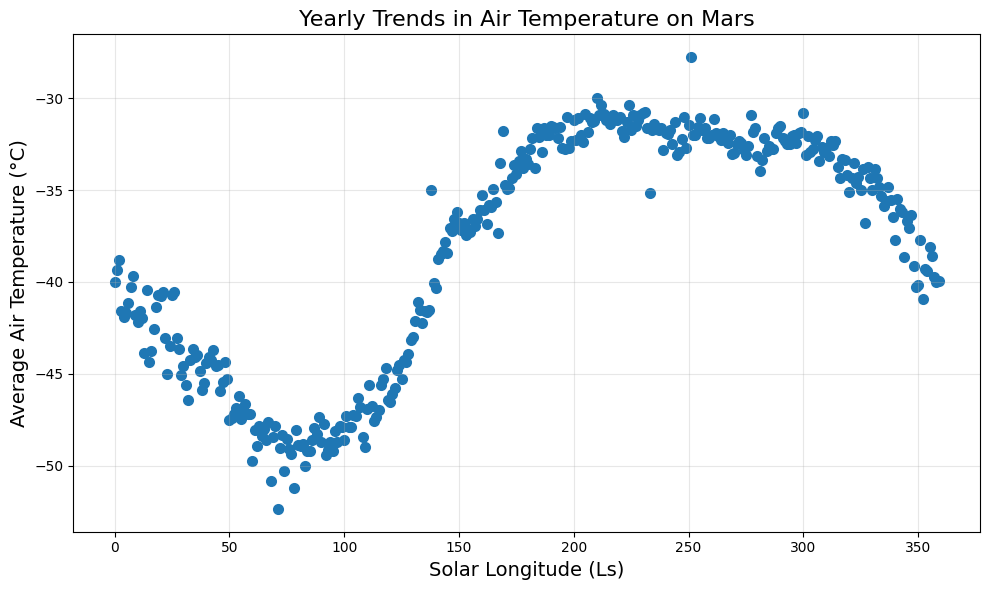

In [33]:
mars_yearly_avg_air_temp = mars_df.groupby('Ls')['avg_air_temp'].mean()

# Plot the average day length for each Martian year
plt.figure(figsize=(10, 6))
plt.scatter(mars_yearly_avg_air_temp.index, mars_yearly_avg_air_temp.values, marker='o', linestyle='-', linewidth=2)
plt.title('Yearly Trends in Air Temperature on Mars', fontsize=16)
plt.xlabel('Solar Longitude (Ls)', fontsize=14)
plt.ylabel('Average Air Temperature (°C)', fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()

# Save Figure
plt.savefig(os.path.join(PLOT_PATH, '01 - Yearly Trends in Air Temperature on Mars.png'))

# Show the plot
plt.show()

#### **Basic Visualization of Yearly Trends for Average Ground Temperature**

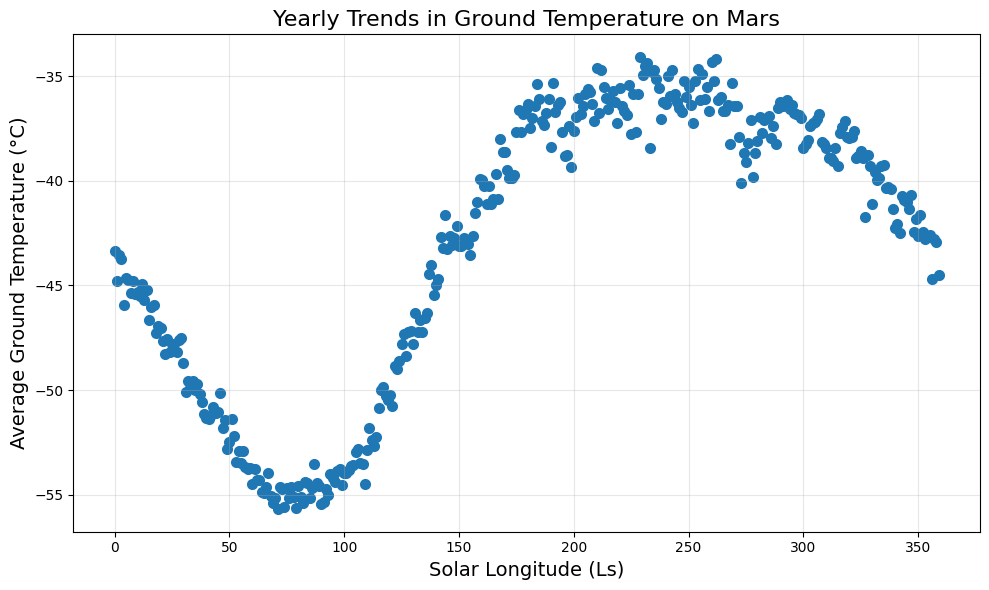

In [34]:
mars_yearly_avg_ground_temp = mars_df.groupby('Ls')['avg_ground_temp'].mean()

# Plot the average day length for each Martian year
plt.figure(figsize=(10, 6))
plt.scatter(mars_yearly_avg_ground_temp.index, mars_yearly_avg_ground_temp.values, marker='o', linestyle='-', linewidth=2)
plt.title('Yearly Trends in Ground Temperature on Mars', fontsize=16)
plt.xlabel('Solar Longitude (Ls)', fontsize=14)
plt.ylabel('Average Ground Temperature (°C)', fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()

# Save Figure
plt.savefig(os.path.join(PLOT_PATH, '01 - Yearly Trends in Ground Temperature on Mars.png'))

# Show the plot
plt.show()

#### **Detailed Visualization of Min, Max, and Average Air Temperatures by Season**

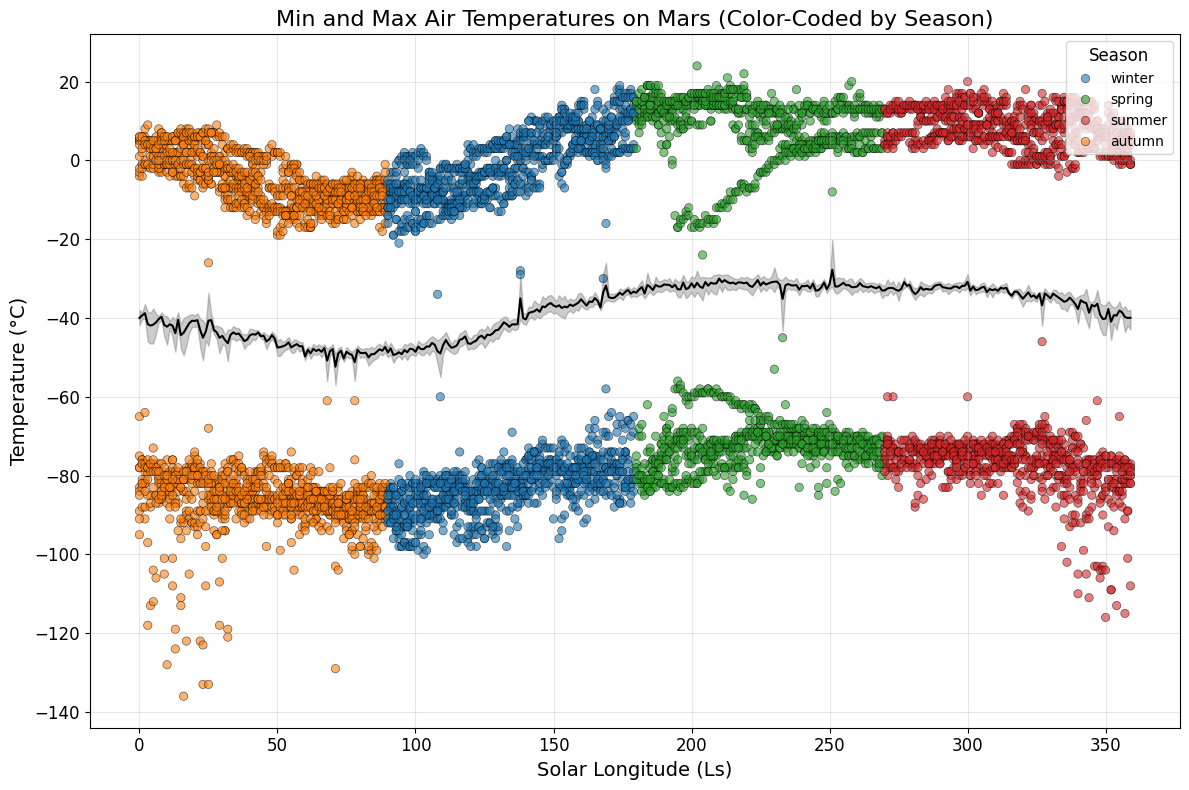

In [35]:
# Define a consistent color palette for the Martian seasons
season_palette = {
    "spring": "#2ca02c",  # Green
    "summer": "#d62728",   # Red
    "autumn": "#ff7f0e",  # Orange
    "winter": "#1f77b4"  # Blue
}

# Set up the figure
plt.figure(figsize=(12, 8))

# Scatter plot for min air temperature
sns.scatterplot(
    data=mars_df,
    x='Ls',
    y='min_air_temp',
    hue='mars_season',
    palette=season_palette,
    alpha=0.6,
    edgecolor='k'
)

# Scatter plot for max air temperature
sns.scatterplot(
    data=mars_df,
    x='Ls',
    y='max_air_temp',
    hue='mars_season',
    palette=season_palette,
    alpha=0.6,
    edgecolor='k'
)

# Line plot for average air temperatures
sns.lineplot(
    data=mars_df,
    x='Ls',
    y='avg_air_temp',
    color='black'
)

# Customize the plot
plt.title('Min and Max Air Temperatures on Mars (Color-Coded by Season)', fontsize=16)
plt.xlabel('Solar Longitude (Ls)', fontsize=14)
plt.ylabel('Temperature (°C)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha=0.3)

# Fix the legend to avoid duplicates
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
plt.legend(unique_labels.values(), unique_labels.keys(), title='Season', fontsize=10, title_fontsize=12, loc='upper right')

plt.tight_layout()

# Save Figure
plt.savefig(os.path.join(PLOT_PATH, '01 - Min and Max Air Temperatures on Mars (Color-Coded by Season).png'))

# Show the plot
plt.show()

#### **Detailed Visualization of Min, Max, and Average Ground Temperatures by Season**

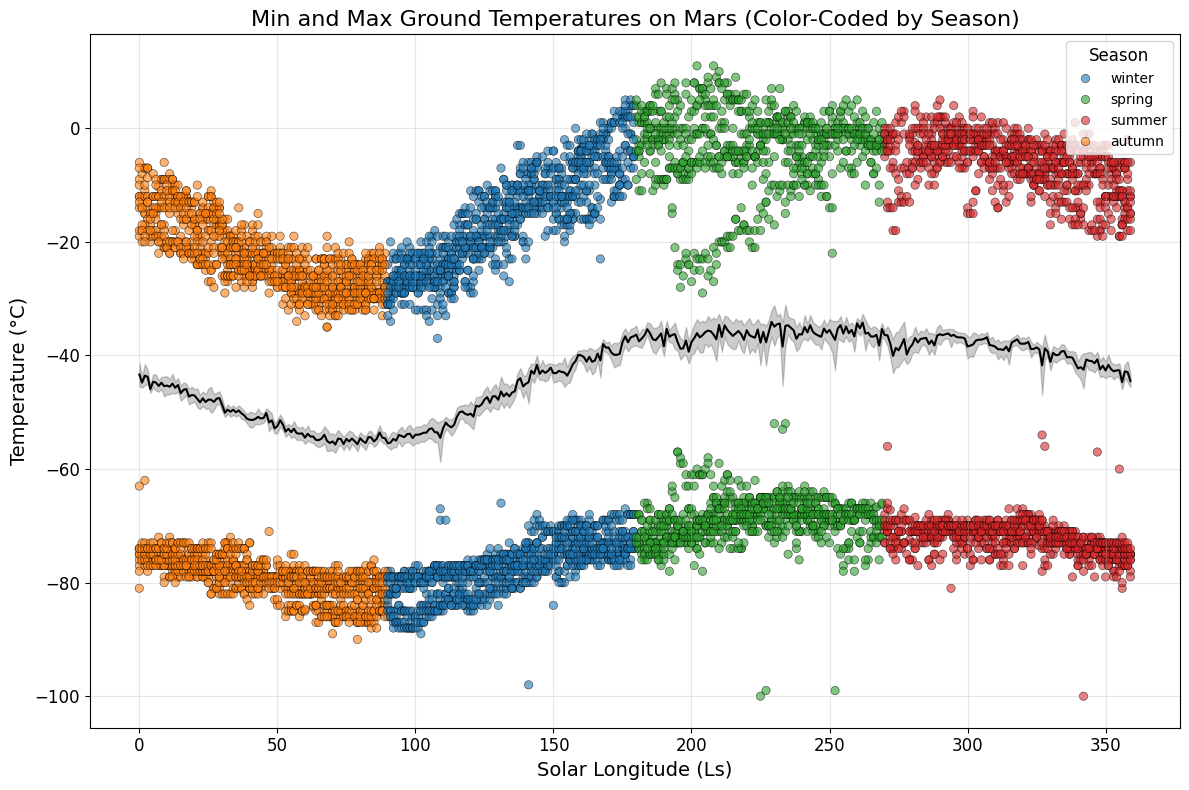

In [36]:
# Set up the figure
plt.figure(figsize=(12, 8))

# Scatter plot for min air temperature
sns.scatterplot(
    data=mars_df,
    x='Ls',
    y='min_ground_temp',
    hue='mars_season',
    palette=season_palette,
    alpha=0.6,
    edgecolor='k'
)

# Scatter plot for max air temperature
sns.scatterplot(
    data=mars_df,
    x='Ls',
    y='max_ground_temp',
    hue='mars_season',
    palette=season_palette,
    alpha=0.6,
    edgecolor='k'
)

# Line plot for average air temperatures
sns.lineplot(
    data=mars_df,
    x='Ls',
    y='avg_ground_temp',
    color='black'
)

# Customize the plot
plt.title('Min and Max Ground Temperatures on Mars (Color-Coded by Season)', fontsize=16)
plt.xlabel('Solar Longitude (Ls)', fontsize=14)
plt.ylabel('Temperature (°C)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha=0.3)

# Fix the legend to avoid duplicates
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
plt.legend(unique_labels.values(), unique_labels.keys(), title='Season', fontsize=10, title_fontsize=12, loc='upper right')

plt.tight_layout()

# Save Figure
plt.savefig(os.path.join(PLOT_PATH, '01 - Min and Max Ground Temperatures on Mars (Color-Coded by Season).png'))

# Show the plot
plt.show()

### **5.2 UV Radiation Visualizations**

#### **KDE + Histogram of UV Radiation Category Distributions**

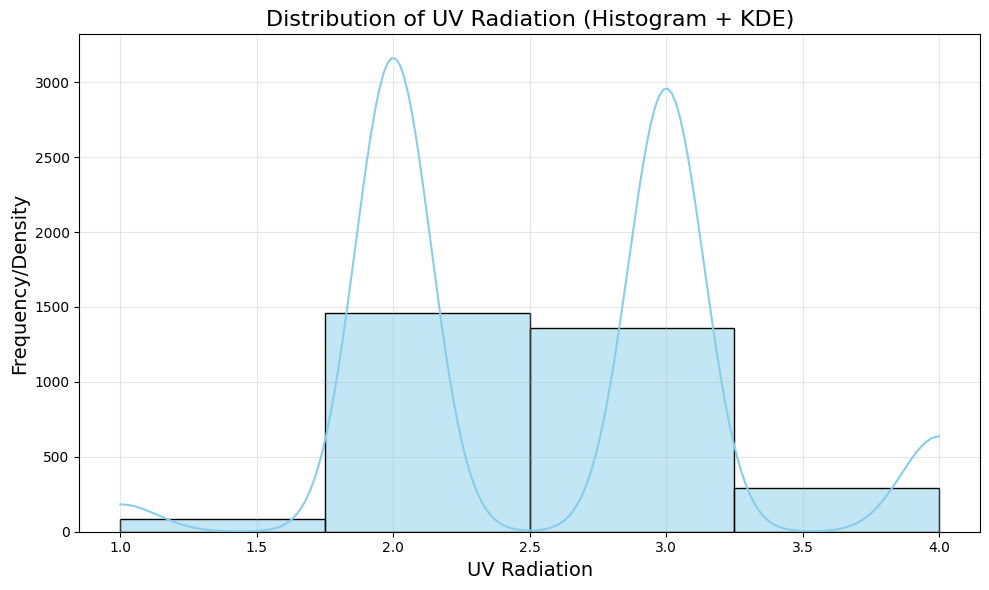

In [37]:
# Combined plot (Histogram + KDE)
plt.figure(figsize=(10, 6))
sns.histplot(mars_df['UV_Radiation'], bins=4, kde=True, color='skyblue', edgecolor='black')
plt.title('Distribution of UV Radiation (Histogram + KDE)', fontsize=16)
plt.xlabel('UV Radiation', fontsize=14)
plt.ylabel('Frequency/Density', fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()

# Save Figure
plt.savefig(os.path.join(PLOT_PATH, '01 - Distribution of UV Radiation (Histogram + KDE)'))

# Show Figure
plt.show()

#### **KDE + Histogram Distributions for Key Features**

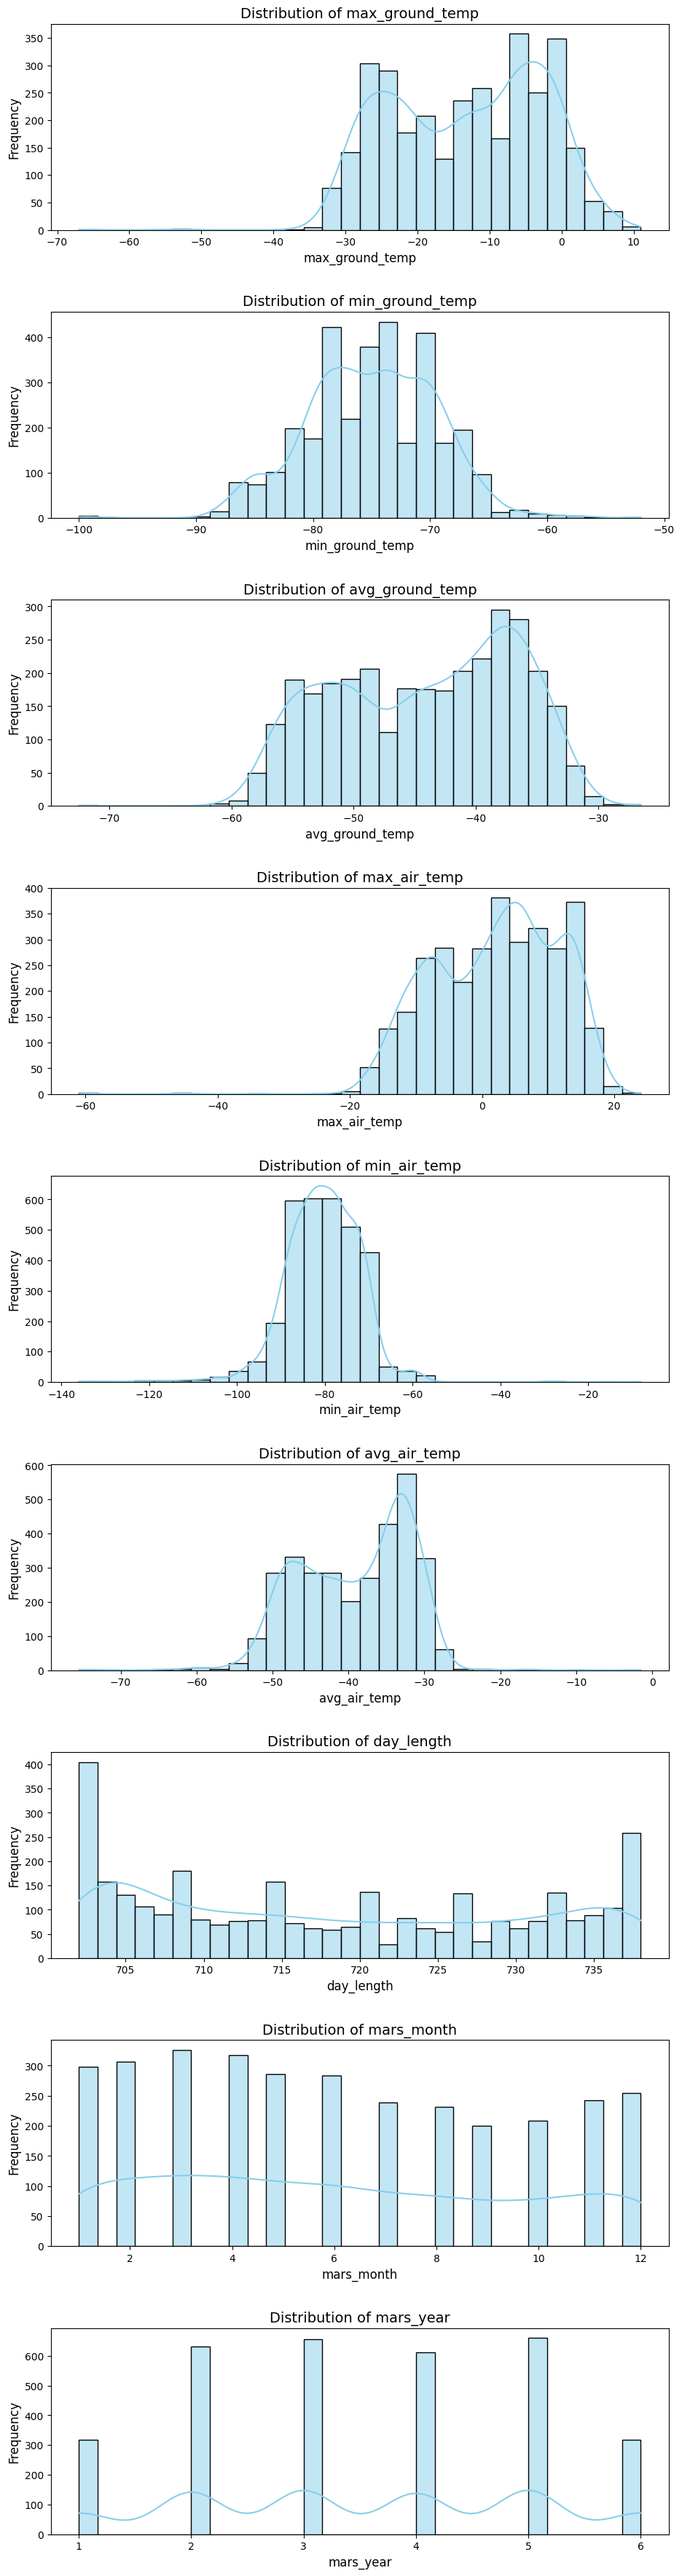

In [38]:
# Create list containing primary features of interest
col = ['max_ground_temp', 'min_ground_temp', 'avg_ground_temp', 
       'max_air_temp', 'min_air_temp', 'avg_air_temp', 
       'day_length', 'mars_month', 'mars_year']

# Filter numeric columns only
numeric_cols = [c for c in col if mars_df[c].dtype in ['float64', 'int64']]

# Set up the figure with appropriate height for each subplot
plt.figure(figsize=(10, len(numeric_cols) * 4))

for i, feature in enumerate(numeric_cols, start=1):
    plt.subplot(len(numeric_cols), 1, i)
    sns.histplot(data=mars_df, x=feature, kde=True, bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {feature}', fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)

# Adjust spacing between subplots
plt.tight_layout(pad=3.0)

# Save Figure
plt.savefig(os.path.join(PLOT_PATH, '01 - Histogram and KDE Distributions of Key Features.png'))

# Show Figure
plt.show()